# Testing Data Processing

## Define necessary variables

In [1]:
# Create a directory to save the files
save_dir = './../data/vietnam_cloud_data'
# List of selected years
years = ['2001', '2003', '2005', '2007', '2009', '2011', '2013', '2015', '2017', '2019', '2021', '2023']
# List of selected months
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
# List of selected days
days = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
# Time intervals for every 2 hours
times = ['00:00', '02:00', '04:00', '06:00', '08:00', '10:00', '12:00', '14:00', '16:00', '18:00', '20:00', '22:00']
# North, West, South, East coordinates for Vietnam
vietnam_area = [23, 102, 8, 110]

## Pull data from cds api

Get the api keys and pull data from the [CDS Website](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)
Be mindful of the data limit per request to split up downloads accordingly.

In [ ]:
import os
import cdsapi

# Create the directory if it does not exist
os.makedirs(save_dir, exist_ok=True)

# Initialize the CDS API client
c = cdsapi.Client()

# Loop over each year and retrieve data
for year in years:
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': [
                'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover',
                'total_column_cloud_ice_water', 'total_column_cloud_liquid_water'
            ],
            'year': year,
            'month': days,
            'day': days,
            'time': times,
            'area': vietnam_area,
        },
        os.path.join(save_dir, f'vietnam_cloud_data_{year}.nc')
    )

## Preprocess downloaded data

### Combine data files

Combine all the separately downloaded file into one and load into panda dataframe.

In [5]:
import xarray as xr
import pandas as pd

years = ['2001', '2003', '2005', '2007']

# List of yearly files
yearly_files = [f'./../data/vietnam_cloud_data/vietnam_cloud_data_{year}.nc' for year in years]

# Load datasets and inspect their time coordinates
datasets = []
for file, year in zip(yearly_files, years):
    ds = xr.open_dataset(file)
    # Inspect the time coordinates
    print(f"Time coordinates for {year}: {ds['time'].values}")
    datasets.append(ds)

# Combine datasets
combined_ds = xr.concat(datasets, dim='time')

# Save the combined dataset if needed
combined_ds.to_netcdf('./../data/vietnam_cloud_data/vietnam_cloud_data_combined.nc')

# Print available variables
print(combined_ds.data_vars)

# List of variables with correct names
variables = ['tcc', 'hcc', 'mcc', 'lcc', 'tciw', 'tclw']

# Convert to DataFrame
df = combined_ds[variables].to_dataframe().reset_index()

# Visualize data in the DataFrame
print(df.head())

# Process the DataFrame to handle missing values, etc.
# df = df.dropna()

# Convert timestamps to a datetime format
df['time'] = pd.to_datetime(df['time'])

# Print the count of non-missing values in each column
print(df.count())

# Save the DataFrame to a CSV file for easier inspection if needed
# df.to_csv('data/vietnam_cloud_data_combined.csv', index=False)

Time coordinates for 2001: ['2001-01-01T00:00:00.000000000' '2001-01-01T02:00:00.000000000'
 '2001-01-01T04:00:00.000000000' ... '2001-12-31T18:00:00.000000000'
 '2001-12-31T20:00:00.000000000' '2001-12-31T22:00:00.000000000']
Time coordinates for 2003: ['2003-01-01T00:00:00.000000000' '2003-01-01T02:00:00.000000000'
 '2003-01-01T04:00:00.000000000' ... '2003-12-31T18:00:00.000000000'
 '2003-12-31T20:00:00.000000000' '2003-12-31T22:00:00.000000000']
Time coordinates for 2005: ['2005-01-01T00:00:00.000000000' '2005-01-01T02:00:00.000000000'
 '2005-01-01T04:00:00.000000000' ... '2005-12-31T18:00:00.000000000'
 '2005-12-31T20:00:00.000000000' '2005-12-31T22:00:00.000000000']
Time coordinates for 2007: ['2007-01-01T00:00:00.000000000' '2007-01-01T02:00:00.000000000'
 '2007-01-01T04:00:00.000000000' ... '2007-12-31T18:00:00.000000000'
 '2007-12-31T20:00:00.000000000' '2007-12-31T22:00:00.000000000']
Data variables:
    tcc      (time, latitude, longitude) float64 282MB 1.0 1.0 ... 1.0 1.0
 

### Visualize data

This is will show which column is missing how many values compare to the rest of the dataset.

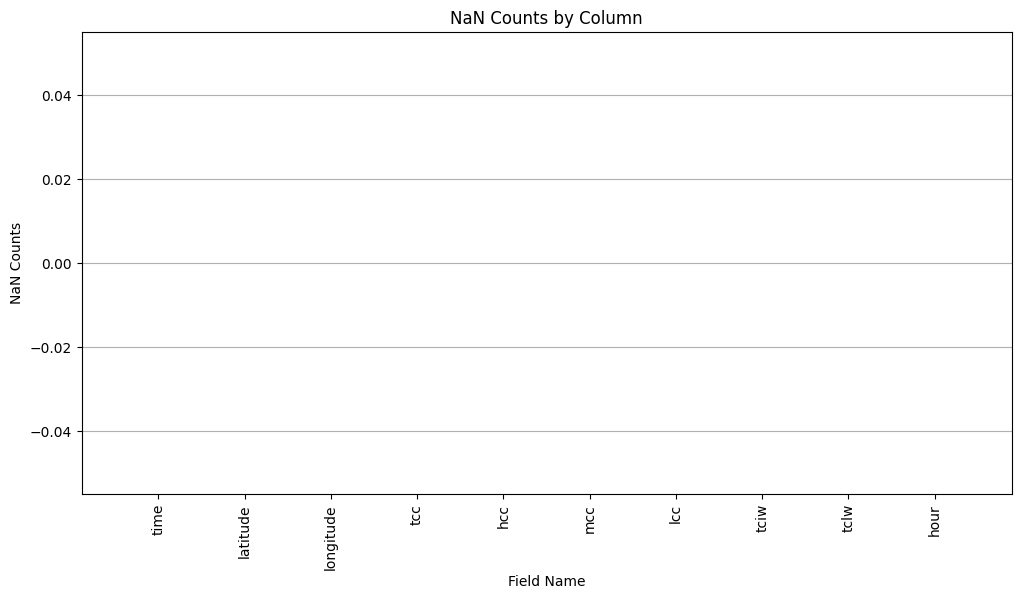

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_nan_counts(df):
    """
    Plots the number of NaN counts for each column in the dataset using Matplotlib.

    Parameters:
    df (pd.DataFrame): The dataset as a Pandas DataFrame.
    """
    # Calculate NaN counts
    nan_counts = df.isna().sum().sort_values(ascending=False).to_frame()
    nan_counts = nan_counts.reset_index()
    nan_counts.columns = ["Field Name", "NaN Counts"]

    # Plot NaN counts
    plt.figure(figsize=(12, 6))
    plt.bar(nan_counts["Field Name"], nan_counts["NaN Counts"], color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel("Field Name")
    plt.ylabel("NaN Counts")
    plt.title("NaN Counts by Column")
    plt.grid(axis='y')
    plt.show()
    
plot_nan_counts(df)

Visualizing data count by hours

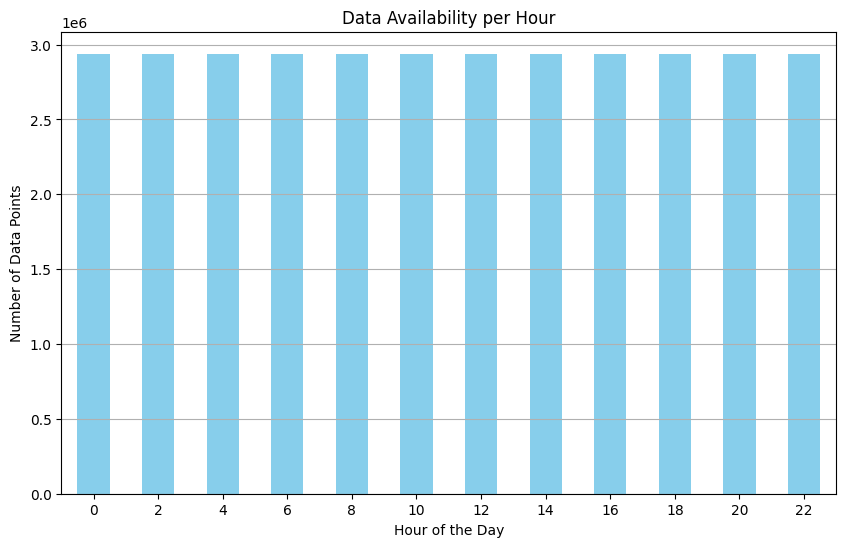

In [9]:
def plot_data_availability_per_hour(df, time_column='time', title="Data Availability per Hour"):
    """
    Plots the total number of data points available per hour in the dataset.

    Parameters:
    df (pd.DataFrame): The dataset as a Pandas DataFrame.
    time_column (str): The name of the column containing the datetime information.
    title (str): The title of the plot.
    """
    # Ensure the time column is in datetime format
    df[time_column] = pd.to_datetime(df[time_column])
    
    # Extract the hour from the datetime column
    df['hour'] = df[time_column].dt.hour
    
    # Group by hour and count the number of records for each hour
    hourly_counts = df.groupby('hour').size()
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    hourly_counts.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Data Points')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()
    
plot_data_availability_per_hour(df)